## Imports

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
sns.set(rc={'figure.figsize' : (12, 6)})
sns.set_style("darkgrid", {'axes.grid' : True})
# plt.style.use('seaborn-whitegrid')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import skimage

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from statsmodels.iolib.table import SimpleTable

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

## Data review
In this competition, you are provided a time-series forecasting problem centered around restaurant visitors. The data comes from two separate sites:
* **Hot Pepper Gourmet (hpg)**: similar to Yelp, here users can search restaurants and also make a reservation online
* **AirREGI / Restaurant Board (air)**: similar to Square, a reservation control and cash register system

From this sites you can use the reservations, visits, and other information to forecast future restaurant visitor totals on a given date. The training data covers the dates from *January 2016 until April 2017*. The test set covers the *last week of April and May of 2017*. The test set is split based on time (the public fold coming first, the private fold following the public) and covers a chosen subset of the air restaurants. Note that the test set intentionally spans a holiday week in Japan called the "Golden Week." There are days in the test set where the restaurant were closed and had no visitors. These are ignored in scoring. The training set omits days where the restaurants were closed.

## Importing Data

In [ ]:
air_res = pd.read_csv('../input/recruit-restaurant-visitor-forecasting/air_reserve.csv')
air_store = pd.read_csv('../input/recruit-restaurant-visitor-forecasting/air_store_info.csv')
hpg_res = pd.read_csv('../input/recruit-restaurant-visitor-forecasting/hpg_reserve.csv')
hpg_store = pd.read_csv('../input/recruit-restaurant-visitor-forecasting/hpg_store_info.csv')
air_visit = pd.read_csv('../input/recruit-restaurant-visitor-forecasting/air_visit_data.csv')
id_rel = pd.read_csv('../input/recruit-restaurant-visitor-forecasting/store_id_relation.csv')

## Explore the data
### File Descriptions
This is a relational dataset from two systems. Each file is prefaced with the source (either air_ or hpg_) to indicate its origin. Each restaurant has a unique air_store_id and hpg_store_id. Note that not all restaurants are covered by both systems, and that you have been provided data beyond the restaurants for which you must forecast. Latitudes and Longitudes are not exact to discourage de-identification of restaurants.

**air_reserve.csv** - This file contains reservations made in the air system. Note that the reserve_datetime indicates the time when the reservation was created, whereas the visit_datetime is the time in the future where the visit will occur.

**hpg_reserve.csv** - This file contains reservations made in the hpg system.

**air_store_info.csv** - This file contains information about select air restaurants. Column names and contents are self-explanatory.

**hpg_store_info.csv** - This file contains information about select hpg restaurants. Column names and contents are self-explanatory.

**store_id_relation.csv** - This file allows you to join select restaurants that have both the air and hpg system.

**air_visit_data.csv** - This file contains historical visit data for the air restaurants.

**sample_submission.csv** - This file shows a submission in the correct format, including the days for which you must forecast.

**date_info.csv** - This file gives basic information about the calendar dates in the dataset.

Firstly, lets look a bit at tables data examples.          
Then try to discover info about it's structure and data types, as they can be not quite correctly represented by the Pandas.

In [ ]:
air_res.head()

In [ ]:
air_res.info()

In [ ]:
air_store.head()

In [ ]:
air_store.info()

In [ ]:
air_visit.head()

In [ ]:
air_visit.info()

In [ ]:
hpg_res.info()

In [ ]:
id_rel.head()

In [ ]:
air_res.air_store_id.nunique() # number of unique restaurants in air system

In [ ]:
hpg_res.hpg_store_id.nunique() # number of unique restaurants in hpg system

In [ ]:
id_rel.air_store_id.nunique() # number of unique restaurants that are in both systems at once

In [ ]:
# Rename some columns before merging
# air_store.rename(columns={"air_genre_name": "genre_name", " B": "c"})

In [ ]:
# Merge tables
air = pd.merge(air_res, air_store, on='air_store_id')
hpg = pd.merge(hpg_res, hpg_store, on='hpg_store_id')

In [ ]:
air_rel = pd.merge(air, id_rel, how='left', on='air_store_id')
hpg_rel = pd.merge(hpg, id_rel, how='left', on='hpg_store_id')
full = pd.merge(air_rel, hpg_rel, how='outer')

In [ ]:
print("In air reservations are: %d \nIn hpg reservations are: %d \nIn both systems at once there are: %d" % \
      (air.shape[0], hpg.shape[0], id_rel.shape[0]))
print("So, totally must be: %d reservations." \
      % (full.shape[0]))

In [ ]:
# Then we need to convert columns 'visit_datetime' and 'reserve_datetime' from object type -> to data/time type
full['visit_datetime'] = pd.to_datetime(full['visit_datetime'])
full['reserve_datetime'] = pd.to_datetime(full['reserve_datetime'])

In [ ]:
full.info()

In [ ]:
# Split converted date-time columns to year, month, date, day of week and time separate coluns of dataset
full['visit_year'] = pd.Series(full.visit_datetime.dt.year)
full['visit_month']  = pd.Series(full.visit_datetime.dt.month)
full['visit_date'] = pd.Series(full.visit_datetime.dt.day)
full['visit_weekday'] = pd.Series(full.visit_datetime.dt.weekday)
full['visit_time'] = pd.Series(full.visit_datetime.dt.time)

In [ ]:
full['reserve_year'] = pd.Series(full.reserve_datetime.dt.year)
full['reserve_month']  = pd.Series(full.reserve_datetime.dt.month)
full['reserve_date'] = pd.Series(full.reserve_datetime.dt.day)
full['reserve_weekday'] = pd.Series(full.reserve_datetime.dt.weekday)
full['reserve_time'] = pd.Series(full.reserve_datetime.dt.time)

In [ ]:
full.head()

In [ ]:
# Fill NaNs to ease operations with ids and creation new columns
full['air_store_id'] = full['air_store_id'].fillna('0')
full['hpg_store_id'] = full['hpg_store_id'].fillna('0')
full['air_genre_name'] = full['air_genre_name'].fillna('0')
full['hpg_genre_name'] = full['hpg_genre_name'].fillna('0')

In [ ]:
# Now lets put our data in order
# Create column 'store_id', where all ids from two sources will be collected together
full.loc[(full['air_genre_name'] != '0'), 'store_id'] = full['air_store_id']
full.loc[(full['air_genre_name'] == '0'), 'store_id'] = full['hpg_store_id']

# Create column 'store_genre_name', where all genres of restaurants will be collected together
full.loc[(full['air_genre_name'] != '0'), 'store_genre_name'] = full['air_genre_name']
full.loc[(full['air_genre_name'] == '0'), 'store_genre_name'] = full['hpg_genre_name']

# Create column 'air_hpg_link', to save connection between restaurants that are in both sources
full.loc[(full['air_store_id'] != '0') & (full['hpg_genre_name'] != '0'), 'air_hpg_link'] = full['air_store_id']
full.loc[(full['air_store_id'] != '0') & (full['hpg_genre_name'] == '0'), 'air_hpg_link'] = full['hpg_store_id']

# Create column 'store_genre_name', where all genres of restaurants will be collected together
full.loc[(full['air_genre_name'] != '0'), 'area_name'] = full['air_area_name']
full.loc[(full['air_genre_name'] == '0'), 'area_name'] = full['hpg_area_name']

full['air_hpg_link'] = full['air_hpg_link'].fillna('0')

In [ ]:
full.head()

## Feature visualisations
Here we have a first look at the distributions of the feature in our data files before taking them for a more detailed analysis. This inital visualisation will be the foundation on which we build our analysis.

We start visualisation with plotting the number of visits to the restaurants. Here we plot the total number of visitors during the full training time (for given period from Jan.2016 to May.2017), then visitors per month (Jan.2016) and per week (04.01.2016-10.01.2016, which also dont't contain holidays):

In [ ]:
fullhist = full.groupby(['visit_datetime'],as_index=False).count().sort_values(by=['visit_datetime'])
fullhist_mnth = fullhist.loc[fullhist['visit_datetime'] <= pd.to_datetime('2016-02-01 23:59:00')]
fullhist_week = fullhist.loc[(fullhist['visit_datetime'] >= pd.to_datetime('2016-01-04 00:00:00')) \
                            & (fullhist['visit_datetime'] <= pd.to_datetime('2016-01-10 23:59:00'))]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(22,25))
ax1.plot(fullhist.visit_datetime, fullhist.store_id)
ax1.set_title("Visits during full period")
plt.ylabel("Number of visits")
plt.grid(True)

ax2.plot(fullhist_mnth.visit_datetime, fullhist_mnth.store_id)
ax2.set_title("Visits during one month")
plt.ylabel("Number of visits")
plt.grid(True)

ax3.plot(fullhist_week.visit_datetime, fullhist_week.store_id)
ax3.set_title("Visits during one week")
plt.ylabel("Number of visits")

plt.xlabel("Period")
plt.grid(True)
plt.show()

And here we will try to show statistics of visits to restaurants in distributed by month, by day of the week and time of day:

In [ ]:
monthshist = full.groupby(['visit_month'],as_index=False).count().sort_values(by=['visit_month'])
weekshist = full.groupby(['visit_weekday'],as_index=False).count().sort_values(by=['visit_weekday'])
dayhist = full.groupby(['visit_time'],as_index=False).count().sort_values(by=['visit_time'])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))

plt.ylabel("Number of visits")
ax1.bar(monthshist.visit_month, monthshist.store_id)
ax1.set_title("Visits by months")
plt.xlabel("Months")

ax2.bar(weekshist.visit_weekday, weekshist.store_id, color='C2')
ax2.set_title("Visits by one week")
plt.xlabel("Week days")

ax3.plot(dayhist.visit_time, dayhist.store_id, color='C1')
ax3.set_title("Visits during one day")
plt.xlabel("Time")

plt.show()

In [ ]:
full.head(1)

In [ ]:
# Create dataset combined by visit date from full data
# Note: that in air data the last datetime of visit is near 05.2017 and in hpg data is ended at 04.2017
# So on last month of period (t.e. May 2017) joined data for both sited is not full!
datehist = full.loc[full['visit_datetime'] < pd.to_datetime('2017-05-01')]
datehist['visit_date_full'] = pd.Series(datehist.visit_datetime.dt.date)
datehist = datehist.groupby(['visit_date_full'],as_index=False).count().sort_values(by=['visit_date_full'])
datehist.tail()

In [ ]:
# Create dataset combined by visit date from months data
date_mnth_hist = datehist.loc[datehist['visit_date_full'] < pd.to_datetime('2016-02-01')]
date_mnth_hist.tail()

## Forecast quality metrics
Before actually forecasting, let’s understand how to measure the quality of predictions and have a look at the most common and widely used metrics:

* **R squared**: coefficient of determination,  (−∞,1]          
It represents the proportion of variance (of y) that has been explained by the independent variables in the model. It provides an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted by the model, through the proportion of explained variance.                         
As such variance is dataset dependent, R² may not be meaningfully comparable across different datasets. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R² score of 0.0.
<img src="https://cdn-images-1.medium.com/max/2568/1*pKx5cF_Fx6nco2KNowSuvA.png" alt="MAE" style="width: 400px;"/>

In Sklearn implemented function: *sklearn.metrics.r2_score*

* **Mean Absolute Error** - a risk metric corresponding to the expected value of the absolute error loss or l1-norm loss. It is an interpretable metric because it has the same unit of measurement as the initial series, [0, +inf)
<img src="http://mund-consulting.com/wp-content/uploads/2014/08/mae1.png" alt="MAE" style="width: 200px;"/>

In Sklearn implemented function: *sklearn.metrics.mean_absolute_error*

* **Mean Squared Error** - a risk metric corresponding to the expected value of the squared (quadratic) error or loss. It is the most commonly used metric that gives a higher penalty to large errors and vice versa, [0,+∞)
<img src="https://s3.amazonaws.com/media-p.slid.es/uploads/759308/images/5478762/pasted-from-clipboard.png" alt="MSE" style="width: 200px;"/>

In Sklearn implemented function: *sklearn.metrics.mean_squared_error*

* **Mean Squared Logarithmic Error** - a risk metric corresponding to the expected value of the squared logarithmic (quadratic) error or loss. Practically, this is the same as MSE, but we take the logarithm of the series. As a result, we give more weight to small mistakes as well. This is usually used when the data has exponential trends, [0,+∞)
<img src="https://raw.githubusercontent.com/DevStarSJ/Study/master/Blog/Kaggle/Coursera.competition/image/coursera.competition.03.07.png" alt="MSLE" style="width: 400px;"/>

In Sklearn implemented function: *sklearn.metrics.mean_squared_log_error*

In [ ]:
# Importing everything from above
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

## Move, smoothe, evaluate: Rolling window estimations
You are conducting an exploratory analysis of this dataset as time-series data. To make sure you have the best picture of your data, you'll want to separate long-trends and seasonal changes from the random fluctuations. In this part, we'll describe some of the time smoothers commonly used to help you do this.

* **Moving averages**       

The easiest local smoother to grasp intuitively is the moving average (or running mean) smoother. It consists of taking the mean of a fixed number of nearby points. As we only use nearby points, adding new data to the end of the time series does not change estimated values of historical results.              
Let’s start with a naive hypothesis — “tomorrow will be the same as today”, but instead of a model like *ŷ(t)=y(t−1)* (which is actually a great baseline for any time series prediction problems and sometimes it’s impossible to beat it with any model) we’ll assume that the future value of the variable depends on the average *n* of its previous values and therefore we’ll use moving average.
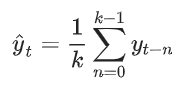
Unfortunately we can’t make this prediction long-term — to get one for the next step we need the previous value to be actually observed. But moving average has another use case — smoothing of the original time series to indicate trends. Pandas has an implementation available *DataFrame.rolling(window).mean()*. The wider the window - the smoother will be the trend. In the case of the very noisy data, which can be very often encountered in finance, this procedure can help to detect common patterns.

In [ ]:
# Calculate average of last n observations
def moving_average(data, n):
    """
    data - series type, which need to be smoothed
    n - size of the moving window
    """
    return np.average(data[-n:])

moving_average(datehist.store_id, 10)

In [ ]:
moving_average(date_mnth_hist.store_id, 10)

In [ ]:
# Or use Pandas implementation - DataFrame.rolling(window).mean(), that provides rolling window calculations.
# As main parameters to this function you should pass: 
# * window - Size of the moving window. This is the number of observations used for calculating the statistic.
# * win_type - Provide a window type.
# Also, note that by default, the result is set to the right edge of the window. 
# This can be changed to the center of the window by setting center=True.
def plotMovingAverage(data, window_size, plot_intervals=False, scale=1.96, plot_anomalies=False):
    """
        data - dataframe with timeseries
        window_size - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    rolling_mean = data.rolling(window=window_size).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window_size))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(data[window_size:], rolling_mean[window_size:])
        deviation = np.std(data[window_size:] - rolling_mean[window_size:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:           # Fix it!!!
            anomalies = pd.DataFrame(index=data.index, columns=[data.name])
            anomalies[data<lower_bond] = data[data<lower_bond]
            anomalies[data>upper_bond] = data[data>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(data[window_size:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

In [ ]:
rolling_mean = date_mnth_hist.rolling(window=4).mean()
rolling_mean.tail()

In [ ]:
# Let's smooth by the previous 7 days so we get weekly trend more clearly.
plotMovingAverage(date_mnth_hist.store_id, 7)

In [ ]:
# Let's smooth by the previous 2 days so we get trend more clearly without loosing extra high values of visitors on weekends.
plotMovingAverage(date_mnth_hist.store_id, 2)

Alse we can compute and plot *confidence intervals* for our smoothed values.            

A **confidence interval (CI)** is a type of interval estimate, computed from the statistics of the observed data, that might contain the true value of an unknown population parameter. The interval has an associated confidence level, or coverage that, loosely speaking, quantifies the level of confidence that the deterministic parameter is captured by the interval. More strictly speaking, the confidence level represents the frequency (i.e. the proportion) of possible confidence intervals that contain the true value of the unknown population parameter. In other words, if confidence intervals are constructed using a given confidence level from an infinite number of independent sample statistics, the proportion of those intervals that contain the true value of the parameter will be equal to the confidence level.

The confidence level is designated prior to examining the data. Most commonly, the 95% confidence level is used. However, other confidence levels can be used, for example, 90% and 99%.                       
We will compute the 95% confidence level for our data.
In other words, the lower endpoint of the 95% confidence interval is:
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/6514f50cf9973fa91a7350e949e4dfa78ec202b8" alt="lower" style="width: 300px;"/>
and the upper endpoint of the 95% confidence interval is:
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/ae05ccddc5e73c2293965a2cdc7c82c8a80a38eb" alt="upper" style="width: 300px;"/>

In [ ]:
# Plot confidence intervals for our smoothed values for a full period
plotMovingAverage(datehist.store_id, 7, plot_intervals=True)

So, when we applied 4 days smoothing on our data, we could clearly see the dynamics of visitors coming in restaurants. During the weekends, the values are higher (more time and occasions to have special dinner on the weekends, or no desire to cook otherwise) while fewer times peaple go there on weekdays.

* **Weighted average**            
Weighted average is a simple modification of the moving average, inside of which observations have different weights summing up to one, usually more recent observations have greater weight.
<img src="https://miro.medium.com/max/1655/1*8IBEmsFCywApUE_joR0aqA.png" alt="weighted average" style="width: 500px;"/>


In [ ]:
def weighted_average(data, weights):
    """
        Calculate weighter average on series
        data - series type, which need to be smoothed
        weights - weights of samples
    """
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += data.iloc[-n-1] * weights[n]
    return float(result)

weighted_average(date_mnth_hist.store_id, [0.6, 0.4, 0.2, 0.1])

* **Exponential smoothing**            
And now let’s take a look at what happens if instead of weighting the last nn values of the time series we start weighting all available observations while exponentially decreasing weights as we move further back in historical data. There’s a formula of the simple exponential smoothing that will help us in that:
<img src="https://miro.medium.com/max/1655/1*8IBEmsFCywApUE_joR0aqA.png" alt="exp smoothing" style="width: 500px;"/>

Here the model value is a weighted average between the current true value and the previous model values. The α weight is called a smoothing factor. It defines how quickly we will “forget” the last available true observation. The less α is the more influence previous model values have, and the smoother the series is.                
Exponentiality is hiding in the recursivity of the function — we multiply each time (1−α) by the previous model value which, in its turn, also containes (1−α) and so forth until the very beginning.

In [ ]:
def exponential_smoothing(data, alpha):
    """
        data - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [data[0]] # first value is same as series
    for n in range(1, len(data)):
        result.append(alpha * data[n] + (1 - alpha) * result[n-1])
    return result

In [ ]:
def plotExponentialSmoothing(data, alphas):
    """
        Plots exponential smoothing with different alphas
        data - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(28, 10))
        for alpha in alphas:
            plt.plot(exponential_smoothing(data, alpha), label="Alpha {}".format(alpha))
        plt.plot(data.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

In [ ]:
plotExponentialSmoothing(date_mnth_hist.store_id, [0.5, 0.3, 0.05])

* **Double exponential smoothing**          

Up to now, the methods that we've discussed have been for a single future point prediction (with some nice smoothing). That is cool, but it is also not enough. Let's extend exponential smoothing so that we can predict two future points (of course, we will also include more smoothing).            

Series decomposition will help us - we obtain two components: **intercept (i.e. level)  ℓ  and slope (i.e. trend)  b** . We have tried to predict intercept (or expected series value) with previous methods; now, we will apply the same exponential smoothing to the trend by assuming that the future direction of the time series changes depends on the previous weighted changes. As a result, we get the following set of functions:
<img src="https://miro.medium.com/max/1783/1*ws6cwxbpczBgTGYEZep79Q.png" alt="exp smoothing 2" style="width: 400px;"/>

As a result we get a set of functions. The first one describes intercept, as before it depends on the current value of the series, and the second term is now split into previous values of the level and of the trend. The second function describes trend — it depends on the level changes at the current step and on the previous value of the trend. In this case β coefficient is a weight in the exponential smoothing. The final prediction is the sum of the model values of the intercept and trend.

In [ ]:
def double_exponential_smoothing(data, alpha, beta):
    """
        data - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [data[0]]
    for n in range(1, len(data)+1):
        if n == 1:
            level, trend = data[0], data[1] - data[0]
        if n >= len(data): # forecasting
            value = result[-1]
        else:
            value = data[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

In [ ]:
def plotDoubleExponentialSmoothing(data, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        data - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(data, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(data.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

In [ ]:
# Let's smooth full data with different settings of parameters (alpha and beta) so we cas see which of them performs the best.
plotDoubleExponentialSmoothing(datehist.store_id, alphas=[0.9, 0.02], betas=[0.9, 0.02])

In [ ]:
# Then try to smooth weekly data with different settings of parameters (alpha and beta).
plotDoubleExponentialSmoothing(fullhist_week.reset_index().store_id, alphas=[0.9, 0.02], betas=[0.9, 0.02])

Now we have to tune two parameters:  α  and  β . The former is responsible for the series smoothing around the trend, the latter for the smoothing of the trend itself. The larger the values, the more weight the most recent observations will have and the less smoothed the model series will be.

So, when we applied 4 different sets of params for exponetial smoothing on our data, we could see, that small parameter values (t.e.alpha=0.2, beta=0.2) lead to incorrect smoothing of the time series, loss of the level line and poor trend display in the data.
Also, the bigger value for alpha is selected, the better trend and level are visible in the data plot.

Certain combinations of the parameters may produce strange results, especially if set manually. We'll look into choosing parameters automatically in a bit; before that, let's discuss triple exponential smoothing.

*  **Triple exponential smoothing a.k.a. Holt-Winters**

We've looked at exponential smoothing and double exponential smoothing. This time, we're going into triple exponential smoothing.

As you could have guessed, the idea is to add a third component - **seasonality**. This means that we should not use this method if our time series is not expected to have seasonality. Seasonal components in the model will explain repeated variations around intercept and trend, and it will be specified by the length of the season, in other words by the period after which the variations repeat. For each observation in the season, there is a separate component: for example, if the length of the season is 7 days (a weekly seasonality), we will have 7 seasonal components, one for each day of the week.

With this, let's write out a new system of equations:
<img src="https://miro.medium.com/max/2153/1*tQUjJKDKmqjGPeQ9YqV_dQ.png" alt="exp smoothing 2" style="width: 400px;"/>

The intercept now depends on the current value of the series minus any corresponding seasonal component. Trend remains unchanged, and the seasonal component depends on the current value of the series minus the intercept and on the previous value of the component. Take into account that the component is smoothed through all the available seasons; for example, if we have a Monday component, then it will only be averaged with other Mondays. Now that we have the seasonal component, we can predict not just one or two steps ahead but an arbitrary  m  future steps ahead, which is very encouraging.

Below is the code for a triple exponential smoothing model, which is also known by the last names of its creators, Charles Holt and his student Peter Winters. Additionally, the Brutlag method was included in the model to produce confidence intervals:
<img src="https://miro.medium.com/max/2053/1*6Cu5nv-COdclmdfXnAU02Q.png" alt="exp smoothing 2" style="width: 400px;"/>

where  T  is the length of the season,  d  is the predicted deviation. Other parameters were taken from triple exponential smoothing. 

You you can read more how to present it in the form of mathematic and calculate [here](https://en.wikipedia.org/wiki/Exponential_smoothing). 

**Implementation of Brutlag's algorithm in Anomaly Detection**         
(You can read more [here](https://annals-csis.org/proceedings/2012/pliks/118.pdf))

In [ ]:
def initial_trend(series, season_len):
    """
    series - initial time series
    season_len - length of a season
    """
    summ = 0.0
    for i in range(season_len):
        summ += float(series[i + season_len] - series[i]) / season_len
    return summ / season_len  

In [ ]:
def initial_seasonal_components(series, season_len):
    """
    series - initial time series
    season_len - length of a season
    """
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series) / season_len)
#     print("n_seasons=%d, len(series)=%d, season_len=%d" % (n_seasons, len(series), season_len))
    # let's calculate season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[season_len*j : season_len*j+season_len]) / float(season_len))
    # let's calculate initial values
    for i in range(season_len):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[season_len*j+i] - season_averages[j]
        seasonals[i] = sum_of_vals_over_avg / n_seasons
    return seasonals   

In [ ]:
def triple_exponential_smoothing(series, season_len, alpha, beta, gamma, n_preds, scaling_factor=1.96):
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    series - initial time series
    season_len - length of a season
    alpha, beta, gamma - Holt-Winters model coefficients
    n_preds - predictions horizon
    scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)   
    """
    result = []
    Smooth = []
    Season = []
    Trend = []
    PredictedDeviation = []
    UpperBond = []
    LowerBond = []  
    seasonals = initial_seasonal_components(series, season_len)
    
    for i in range(len(series) + n_preds):
        if i == 0: # components initialization
            smooth = series[0]
            trend = initial_trend(series, season_len)
            result.append(series[0])
            Smooth.append(smooth)
            Trend.append(trend)
            Season.append(seasonals[i%season_len])
            
            PredictedDeviation.append(0)
            UpperBond.append(result[0] + scaling_factor * PredictedDeviation[0])
            LowerBond.append(result[0] - scaling_factor * PredictedDeviation[0])                   
            continue
                
        if i >= len(series): # predicting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%season_len])
            # when predicting we increase uncertainty on each step
            PredictedDeviation.append(PredictedDeviation[-1]*1.01)  
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha * (val-seasonals[i%season_len]) + (1-alpha) * (smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%season_len] = gamma*(val-smooth) + (1-gamma)*seasonals[i%season_len]
            result.append(smooth+trend+seasonals[i%season_len])
            # Deviation is calculated according to Brutlag algorithm.
            PredictedDeviation.append(gamma * np.abs(series[i] - result[i]) + (1-gamma)*PredictedDeviation[-1])         
            UpperBond.append(result[-1] + scaling_factor * PredictedDeviation[-1])
            LowerBond.append(result[-1] - scaling_factor * PredictedDeviation[-1])
            Smooth.append(smooth)
            Trend.append(trend)
            Season.append(seasonals[i%season_len])
    return[result, LowerBond, UpperBond]

In [ ]:
with plt.style.context('seaborn-white'): 
        plt.figure(figsize=(20, 8))
        plt.plot(triple_exponential_smoothing(date_mnth_hist.store_id, 7, 0.4, 0.5, 0.5, 7)[0], label = "Smoothed")
        plt.plot(date_mnth_hist.store_id, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Holt-Winters model Smoothing")
        plt.grid(True)

As we can see from the time series smoothing plot, random selection of parameters for the model does not bring the expected results: the smoothed values of the series are larger than the actual values, which denies the idea of exponential smoothing. That is why we'd better should think about the automatic selection of Holt-Winters model coefficients (alpha, beta and gamma).

## Time series cross validation
Before we start building model let’s talk first about how to estimate model parameters automatically.
There’s nothing unusual here, as always we have to choose a loss function suitable for the task, that will tell us how close the model approximates data. Then using cross-validation we will evaluate our chosen loss function for given model parameters, calculate gradient, adjust model parameters and so forth, bravely descending to the global minimum of error.

The question is how to do cross-validation on time series, because, you know, time series do have time structure and one just can’t randomly mix values in a fold without preserving this structure, otherwise all time dependencies between observations will be lost. That’s why we will have to use a bit more tricky approach to optimization of the model parameters: **“cross-validation on a rolling basis”**.

The idea is rather simple — we train our model on a small segment of the time series, from the beginning until some t, make predictions for the next t+n steps and calculate an error. Then we expand our training sample until t+n value and make predictions from t+n until t+2∗n, and we continue moving our test segment of the time series until we hit the last available observation. As a result we have as many folds as many n will fit between the initial training sample and the last observation. Read more [here](https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection).

To make things intuitive, here is an image for same:

<img src="https://i.stack.imgur.com/fXZ6k.png" alt="cross-validation on a rolling basis" style="width: 600px;"/>

Now, knowing how to set cross-validation, we will find optimal parameters for the Holt-Winters model, recall that we have daily seasonality in moths data, hence the season_len=7 parameter.

In [ ]:
from sklearn.model_selection import TimeSeriesSplit # you have time seriaes splitting already done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, season_len=7):
    """
        Returns error on CV  
        params - vector of parameters for optimization
        series - dataset with timeseries
        season_len - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=5) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):
        res = triple_exponential_smoothing(series=values[train], season_len=season_len, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))[0]
        predictions = res[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In the Holt-Winters model, as well as in the other models of exponential smoothing, there's a constraint on how large the smoothing parameters can be, each of them ranging from 0 to 1. Therefore, in order to minimize our loss function, we have to choose an algorithm that supports constraints on model parameters. In our case, we will use the **truncated Newton conjugate gradient**, also known as Hessian-free optimization.

A truncated Newton method consists of repeated application of an iterative optimization algorithm to approximately solve Newton's equations, to determine an update to the function's parameters. The inner solver is truncated, i.e., run for only a limited number of iterations. It follows that, for truncated Newton methods to work, the inner solver needs to produce a good approximation in a finite number of iterations; conjugate gradient has been suggested and evaluated as a candidate inner loop.

Read more about truncated Newton conjugate gradient [here](http://www.cs.toronto.edu/~jmartens/docs/Deep_HessianFree.pdf) ( and for Russian speakers [here](https://habr.com/ru/post/350794/)).

In [ ]:
# leave some data for testing = one month
test_period_len = 30

In [ ]:
from scipy.optimize import minimize              # for function minimization

%time
data = datehist.store_id[:-test_period_len] # leave some data for testing = one month

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimization of loss function of one or more variables.
opt = minimize(timeseriesCVscore, x0=x, args=(data, median_absolute_error), method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Take optimal values
alpha_final, beta_final, gamma_final = opt.x
print("Best alpha=%f, best beta=%f, best gamma=%f" % (alpha_final, beta_final, gamma_final))

# and train the model with them, forecasting for the next 7 days
ret = triple_exponential_smoothing(data, season_len = 7, alpha = alpha_final, beta = beta_final, gamma = gamma_final, n_preds = 7, scaling_factor = 3) 

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
def plotHoltWinters(series, returned, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        returned - list, returned from triple_exponential_smoothing func: (result, LowerBond, UpperBond)
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    [result, LowerBond, UpperBond] = returned
    plt.figure(figsize=(28, 10))
    plt.plot(result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values < LowerBond[:len(series)]] = \
            series.values[series.values < LowerBond[:len(series)]]
        anomalies[series.values > UpperBond[:len(series)]] = \
            series.values[series.values > UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(result[:-7])), y1=UpperBond, y2=LowerBond, alpha=0.2, color = "grey") 
        
    plt.vlines(len(series), ymin=min(LowerBond), ymax=max(UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-test_period_len, len(result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

In [ ]:
plotHoltWinters(datehist.store_id[:-test_period_len], ret, plot_intervals=True, plot_anomalies=True)

Judging by the plots, model was able to approximate quite well the initial time series, capturing the weekly seasonality, overall  trend, and even some anomalies. If you look at the model deviations, you can clearly see that the model reacts quite sharply to changes in the structure of the series but then quickly returns the deviation to the normal values, essentially "forgetting" the past. This feature of the model allows us to quickly build anomaly detection systems, even for noisy series data, without spending too much time and money on preparing the data and training the model.

## Econometric approach

### Stationarity

Before we start modeling we should mention such an important property of time series as stationarity.
If the process is stationary that means it doesn’t change its statistical properties over time, namely mean and variance do not change over time (constancy of variance is also called *homoscedasticity*), also covariance function does not depend on the time (should only depend on the distance between observations). You can see this visually on the pictures from the post of  [Sean Abu](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/):

* The mean of the series should not be a function of time. The red graph below is not stationary because the mean increases over time. alt text

<img src="http://www.seanabu.com/img/Mean_nonstationary.png" alt="1" style="width: 300px;"/>

* The variance of the series should not be a function of time. This property is known as homoscedasticity. Notice in the red graph the varying spread of data over time. alt text

<img src="http://www.seanabu.com/img/Var_nonstationary.png" alt="cross-validation on a rolling basis" style="width: 300px;"/>

* Finally, the covariance of the i th term and the (i + m) th term should not be a function of time. In the following graph, you will notice the spread becomes closer as the time increases. Hence, the covariance is not constant with time for the ‘red series’.

<img src="http://www.seanabu.com/img/Cov_nonstationary.png" alt="cross-validation on a rolling basis" style="width: 300px;"/>

So why stationarity is so important? Because it’s easy to make predictions on the stationary series as we assume that the future statistical properties will not be different from the currently observed. Most of the time series models in one way or the other model and predict those properties (mean or variance, for example), that’s why predictions would be wrong if the original series were not stationary. Unfortunately most of the time series we see outside of textbooks are non-stationary but we can (and should) change this.
So, to fight non-stationarity we have to know our enemy so to say. Let’s see how to detect it. 

There are two ways you can check the stationarity of a time series. The first is by looking at the data. By visualizing the data it should be easy to identify a changing mean or variation in the data. For a more accurate assessment there is the **Dickey-Fuller test**.

### Dickey-Fuller test

The main idea of the Dickey-Fuller test for the stationarity of time series is fact of presence of a unit root. If we can get stationary series from non-stationary using the first difference we call those series integrated of order 1. Null hypothesis of the test — time series is non-stationary, was rejected on the first three charts and was accepted on the last one. We’ve got to say that the first difference is not always enough to get stationary series as the process might be integrated of order d, d > 1 (and have multiple unit roots), in such cases the augmented Dickey-Fuller test is used that checks multiple lags at once.

We can fight non-stationarity using different approaches — various order differences, trend and seasonality removal, smoothing, also using transformations like Box-Cox or logarithmic.

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Dickey-Fuller test criterion: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
        
    test = sm.tsa.adfuller(y)
    print('adf: ', test[0])  
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print('A unit root is present, series are not stationary') 
    else:
        print('No unit roots are present, series are stationary') 
    return 

tsplot(datehist.store_id, lags=30)

The test confirmed the assumptions about the unstationary of the series. In many cases, taking the difference of the series allows to bring series to stationariry. If, for example, the first differences of a series are stationary, it is called an *integrated series of the first order*.
So let's define the order of the integrated series for our series:

In [ ]:
data_diff1 = datehist.store_id.diff(periods=1).dropna()
tsplot(data_diff1, lags=30)

As can be seen from the plots above, the resulting series of first differences approached the stationary one. To be sure, we will break it into several intervals and make sure the mean value is equal on the different intervals:

In [ ]:
m = data_diff1.index[len(data_diff1.index)//2+1]
r1 = sm.stats.DescrStatsW(data_diff1[m:])
r2 = sm.stats.DescrStatsW(data_diff1[:m])
print('p-value: ', sm.stats.CompareMeans(r1,r2).ttest_ind()[1]) 

A high p-value lets us to assume that the null hypothesis of equality of means is correct, which indicates the stationarity of the series.

## SARIMA model

For predicting we will use model **SARIMA**(p,d,q)(P,D,Q,s), which stands for **Seasonal Autoregression Moving Average model**.

There are seasonal and Non-seasonal ARIMA models that can be used for forecasting. Both of them base on two of the following simple models:
* **AR(p)** — autoregression model, i.e., regression of the time series onto itself. Basic assumption — current series values depend on its previous values with some lag (or several lags). The maximum lag in the model is referred to as p. To determine the initial p you need to have a look at PACF plot — find the biggest significant lag, after which most other lags are becoming not significant.
* **MA(q)** — moving average model. Without going into detail it models the error of the time series, again the assumption is — current error depends on the previous with some lag, which is referred to as q. Initial value can be found on ACF plot with the same logic.

If we combine AR and MA models we'll get **ARMA(p,q)** model - **Autoregressive–moving-average model**.              

Then, adding new components to ARMA model we comes to **ARIMA(p,d,q)** - **Auto Regressive Integrated Moving Average**, which knows how to handle non-stationary data with the help of nonseasonal differences. In an ARIMA model we transform a time series into stationary one(series without trend or seasonality) using differencing. 

* **I(d)** — order of integration. It is simply the number of nonseasonal differences needed for making the series stationary. In our case it’s just 1, because we used first differences.

**Seasonal ARIMA (SARIMA) models**:
As the name suggests, this model is used when the time series exhibits seasonality. This model is similar to ARIMA models, we just have to add in a few parameters to account for the seasons.

* **S(s)** — this letter is responsible for seasonality and equals the season period length of the series

So we write SARIMA as ARIMA(p,d,q)(P, D, Q)m:                 
p — the number of autoregressive                  
d — degree of differencing                     
q — the number of moving average terms                    
m — refers to the number of periods in each season                           
(P, D, Q )— represents the (p,d,q) for the seasonal part of the time series

Now that we know how to set the initial parameters, let's have a look at the final plot once again and set the parameters:

In [ ]:
tsplot(data_diff1, lags=30)

* p  is most probably 6 since it is the last significant lag on the PACF, after which, most others are not significant.
* d  equals 1 because we had first differences
* q  should be somewhere around 6 as well as seen on the ACF
* P  might be 3, since 7-th and 15-th lags are somewhat significant on the PACF (lets the season be 7)
* D  again equals 1 because we performed seasonal differentiation
* Q  is probably 5. The 28-th lag on ACF is significant.

Let's test various models and see which one is better.

In [ ]:
# setting initial values and some bounds for them
ps = range(3, 6)
d=1 
qs = range(3, 6)
Ps = range(3, 5)
D=1 
Qs = range(3, 5)
s = 7 # season length is still 7

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

In [ ]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(data_diff1, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [ ]:
# %time
# result_table = optimizeSARIMA(parameters_list, d, D, s)

In [ ]:
# set the parameters that give the lowest AIC
# p, q, P, Q = result_table.parameters[0]
p = 5
q = 5
P = 3
Q = 3
print("p = %f, q = %f, P = %f, Q = %f" % (p, q, P, Q))

In order not to search for optimal parameters again and not to consider all combinations again, lets take from the grid of parameters the set that gives the lowest AIC and fix them (thus saving time):
* p  = 5
* d  = 1
* q  = 5
* P  = 3
* D  = 1
* Q  = 3


In [ ]:
best_model=sm.tsa.statespace.SARIMAX(data_diff1, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

As you can see from this information in our model all the coefficients are significant and you can proceed to the evaluation of the model.

## Model analysis and evaluation
Let's check the residuals of this model for compliance with "white noise", and also analyze the residuals' correlogram, as it can help us to identify important elements of regression for inclusion and prediction.

### Autocorellation
Autocorrelation of residues is observed when the values of previous residues overestimate (**positive**) or underestimate (**negative**) values of following ones.

* **Positive autocorrelation** on the residuals graph is occur in alternating zones of positive and negative residuals:
<img src="https://konspekta.net/lektsiiorgimg/baza3/1413867055430.files/image529.gif" alt="Positive autocorrelation" style="width: 400px;"/>

* **Negative autocorrelation** on the chart is showed in the fact that the residuals "too often" change sign:
<img src="https://pandia.ru/text/78/207/images/image052_0.gif" alt="Negative autocorrelation" style="width: 400px;"/>

Also, note, that the presence of autocorrelation of random errors of the regression model on it's  residuals' correlogram leads to a deterioration in the quality of estimations of regression parameters, as well as to overestimation of test statistics, which are used to check the quality of the model (that is, an fake improvement in the quality of the model relative to its actual level of accuracy). 
Therefore, testing the autocorrelation of random errors is a necessary procedure for constructing a regression model.


### Ljung–Box Q-test

So the first thing we do is we do a Ljung–Box Q-test to try the hypothesis that the residuals are random, i.e. are " white noise." This test is carried out on the remains of the ARIMA model. Thus, we need to first obtain the residuals of the model and construct an ACF for them, and then apply the test to the resulting coefficient. 

**The Ljung–Box test** (named for Greta M. Ljung and George E. P. Box) is a type of statistical test of whether any of a group of autocorrelations of a time series are different from zero and instead of testing randomness at each distinct lag, it tests the "overall" randomness based on a number of lags, and is therefore a portmanteau test.

The Ljung–Box test may be defined as:

* H0: The data are independently distributed (i.e. the correlations in the population from which the sample is taken are 0, so that any observed correlations in the data result from randomness of the sampling process).
* H1: The data are not independently distributed; they exhibit serial correlation.              
The test statistic is:
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/bb68b5d73ab4813712778e246303961ae48d6190" alt="The Ljung–Box stats" style="width: 200px;"/>
For significance level α, the critical region for rejection of the hypothesis of randomness is: <img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/2aa39af3127113dd435272f4117a64bdd431593d" alt="The Ljung–Box stats" style="width: 120px;"/>

With statsmodels this can be done as follows:

In [ ]:
# Firstly let's inspect the residuals of the model.
tsplot(best_model.resid[7+1:], lags=30)

It is clear that the residuals are stationary, and there are no apparent autocorrelations.

In [ ]:
#  resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
# Calculate the autocorrelation function.
q_test = sm.tsa.stattools.acf(best_model.resid[7+1:], qstat=True) 
acf_scores = pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]})
acf_scores

The value of these statistics and p-values indicate that the hypothesis of the randomness of residues is not rejected, and most likely this process represents "white noise".                       
Now let's calculate the *coefficient of determination R²* to understand what percentage of observations this model describes. For this  let's make predictions using our model.

In [ ]:
data = pd.DataFrame.from_dict({'actual':data_diff1})
data['sarima_model'] = best_model.fittedvalues
forecast = best_model.predict(start = data.shape[0], end = data.shape[0]+ 14)
forecast = data.sarima_model.append(forecast)
# forecast.tail()
data.sarima_model.shape

In [ ]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = pd.DataFrame.from_dict({'actual':data_diff1})
    data['sarima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['sarima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.sarima_model.append(forecast)
    
    # calculate estimations of the last 2 weeks of predictions (which are still registered in actual data) 
    true = data.actual[data.shape[0]-n_steps:data.shape[0]]
    pred = data.sarima_model[data.shape[0]-n_steps:data.shape[0]]
    r2 = r2_score(true, pred)
    mae = mean_absolute_error(true, pred)
    mse = mean_squared_error(true, pred)
    print("R2 = %f, MSE = %f, MAE = %f" % (r2, mse, mae))

    plt.figure(figsize=(22, 7))
    plt.title("SARIMA Model Predictions Plot")
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

plotSARIMA(data_diff1, best_model, 14)

As we see, coefficient of determination R2 is quite high, something around 0.7428.                    
R2 is a statistic that can give some information about the goodness of fit of a model. In AR models, the R2 coefficient of determination is a statistical measure of how well the regression predictions approximate the real data points. An R2 of 1 indicates that the regression predictions perfectly fit the data.                           
So then, our model proved to be good at predicting last 2 weeks of time series.

# Other linear and not models on time series
Often, it is needed to build models fast, good, cheap. That means that some of these models will never be considered "fast" to buid as they demand too much time for data preparation (as in SARIMA) or require frequent re-training on new data (again, SARIMA) or are difficult to tune (good example - SARIMA). Therefore, it's very often much easier to select a few features from the existing time series and build a simple linear regression model or, say, a random forest.               
Thus, lets start from **Feature Extraction**.

## Lags of time series
Shifting the series  n  steps back, we get a feature column where the current value of time series is aligned with its value at time  t−n . If we make a 1 lag shift and train a model on that feature, the model will be able to forecast 1 step ahead from having observed the current state of the series. Increasing the lag, say, up to 6, will allow the model to make predictions 6 steps ahead; however it will use data observed 6 steps back. If something fundamentally changes the series during that unobserved period, the model will not catch these changes and will return forecasts with a large error. Therefore, during the initial lag selection, one has to find a balance between the optimal prediction quality and the length of the forecasting horizon.

In [ ]:
# Create dataset combined by visit date from full data
# Note: that in air data the last datetime of visit is near 05.2017 and in hpg data is ended at 04.2017
# So on last month of period (t.e. May 2017) joined data for both sited is not full!
# dthist = full.loc[full['visit_datetime'] < pd.to_datetime('2017-05-01')]
# dthist['visit_date_full'] = pd.Series(datehist.visit_datetime.dt.date)
# dthist = dthist.groupby(['visit_date_full'],as_index=False).count().sort_values(by=['visit_date_full'])

In [ ]:
# Creating a copy of the initial datagrame to make various transformations 
datehist_timeidx = datehist.set_index('visit_date_full')
data = pd.DataFrame(datehist_timeidx.store_id.copy())
data.columns = ["y"]
# Adding the lag of the target variable from 7 steps back up to 21
for i in range(7, 22):
    data["lag_{}".format(i)] = data.y.shift(i)
data.tail()

So we have generated a whole dataset here. Now we can build and train a model:

In [ ]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

# Create and train linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

In [ ]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs actual values, prediction intervals and anomalies
    """
#     Make prediction
    prediction = model.predict(X_test)
    with plt.style.context('seaborn-white'): 
        plt.figure(figsize=(22, 7))
        plt.plot(prediction, "g", label="prediction", linewidth=2.0)
        plt.plot(y_test.values, label="actual", linewidth=2.0)
    
        if plot_intervals:
            cv = cross_val_score(model, X_train, y_train, cv=tscv, scoring="neg_mean_absolute_error")                         
            mae = cv.mean() * (-1)
            deviation = cv.std()
        
            scale = 1.96
            lower = prediction - (mae + scale * deviation)
            upper = prediction + (mae + scale * deviation)
        
            plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
            plt.plot(upper, "r--", alpha=0.5)
        
            if plot_anomalies:
                anomalies = np.array([np.NaN]*len(y_test))
                anomalies[y_test<lower] = y_test[y_test<lower]
                anomalies[y_test>upper] = y_test[y_test>upper]
                plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
        error = mean_absolute_percentage_error(prediction, y_test)
        plt.title("Mean absolute percentage error {0:.2f}%".format(error))
        plt.legend(loc="best")
        plt.tight_layout()
        plt.grid(True)

In [ ]:
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    with plt.style.context('seaborn-white'): 
        coefs = pd.DataFrame(model.coef_, X_train.columns)
        coefs.columns = ["coef"]
        coefs["abs"] = coefs.coef.apply(np.abs)
        coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
        plt.figure(figsize=(22, 7))
        coefs.coef.plot(kind='bar')
        plt.grid(True, axis='y')
        plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')

In [ ]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

Simple lags and linear regression gave us predictions that are so bad in terms of quality and up to it's simplicity. There are many unnecessary features, so we'll do feature selection in a little while.

As it was done before, we'll add day of week, a boolean for is_weekend and boolean for is_holiday, which represents the days of public and common local [holidays in Japan](https://www.timeanddate.com/calendar/?year=2017&country=26).                
To do so, we need to transform the current dataframe index into the datetime format and extract hour and weekday.

In [ ]:
data.index = pd.to_datetime(data.index)
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
# List of public and common local holidays in Japan
holidays = pd.to_datetime(pd.Series(['01.01.2016', '02.01.2016', '03.01.2016', '11.01.2016', '11.02.2016', '03.03.2016', '20.03.2016', '21.03.2016', \
           '29.04.2016', '03.05.2016', '04.05.2016', '05.05.2016', '07.07.2016', '18.07.2016', '11.08.2016', '19.09.2016', \
           '22.09.2016', '10.10.2016', '03.11.2016', '15.11.2016', '23.11.2016', '23.12.2016', '25.12.2016', '31.12.2016', \
           '01.01.2017', '02.01.2017', '03.01.2017', '09.01.2017', '11.02.2017', '03.03.2017', '20.03.2017', '29.04.2017']))
data['is_holiday'] = data.index.isin(holidays)*1
data.tail()

Lets try to make features visible:

In [ ]:
def plotFeatures(df, features):
    """
    Visualizing features of data
    df - dataframe,from which featuresare taken
    features - list of features
    """
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(22, 7))
        plt.title("Encoded features")
        for i in range(0, len(features)):
            plt.plot(data[features[i]], label=features[i], linewidth=2.0)
        plt.grid(True)
        plt.legend(loc="best")

In [ ]:
ftrs = ['weekday', 'is_weekend', 'is_holiday']
plotFeatures(data, ftrs)

Since we now have different scales in our variables, thousands for the lag features and tens for categorical, we need to transform them into same scale for exploring feature importance and, later, regularization.               
It needed because regularization assume that all features are centered around zero and have variance in the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

The simplest transformation is Standard Scaling (or Z-score normalization):
<img src="https://miro.medium.com/max/178/1*l3GMKe44JVe8YKQi8ZdWgQ.png" alt="The Ljung–Box stats" style="width: 150px;"/>
This type of normalization is implemented in Sklearn as *StandardScaler()*,
that standardize features by removing the mean and scaling to unit variance.


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Create and train linear regression again
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

# But this time perform normalization on the data 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

Surprisingly, but the features of data, we have created from date-time indexes, from the point of view of the model, were not very useful. Also from the plot it is notisable, that we've chosen the period of seasonally right: 7-th lag in data features is the most significant factor in model, then 14-th, 21-st and so on. Thus, we clearly see seasonality in our dataset.                
Then pay your attention that the test error goes down a little bit at this time. 

### Target encoding

I'd like to add another variant for encoding categorical variables: *encoding by mean value*. If it is undesirable to explode a dataset by using many dummy variables that can lead to the loss of information and if they cannot be used as real values because of the conflicts like "0 hours < 23 hours", then it's possible to encode a variable with slightly more interpretable values. The natural idea is to encode with the mean value of the target variable. In our example, every day of the week and every hour of the day can be encoded by the corresponding average number of ads watched during that day or hour. It's very important to make sure that the mean value is calculated over the training set only (or over the current cross-validation fold only) so that the model is not aware of the future.

In [ ]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [ ]:
average_wd = code_mean(data, 'weekday', "y")
plt.figure(figsize=(7, 5))
plt.title("Weekday averages")
pd.DataFrame.from_dict(average_wd, orient='index')[0].plot()
plt.grid(True);

In [ ]:
# Finally, let's put all the transformations together in a single function .
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
#     data_timeidx = datehist.set_index('visit_date_full')    
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
    data.index = pd.to_datetime(data.index)
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    # List of public and common local holidays in Japan
    holidays = pd.to_datetime(pd.Series(['01.01.2016', '02.01.2016', '03.01.2016', '11.01.2016', '11.02.2016', '03.03.2016', '20.03.2016', '21.03.2016', \
               '29.04.2016', '03.05.2016', '04.05.2016', '05.05.2016', '07.07.2016', '18.07.2016', '11.08.2016', '19.09.2016', \
               '22.09.2016', '10.10.2016', '03.11.2016', '15.11.2016', '23.11.2016', '23.12.2016', '25.12.2016', '31.12.2016', \
               '01.01.2017', '02.01.2017', '03.01.2017', '09.01.2017', '11.02.2017', '03.03.2017', '20.03.2017', '29.04.2017']))
    data['is_holiday'] = data.index.isin(holidays)*1
    
    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))

        # drop encoded variables 
        data.drop(["weekday"], axis=1, inplace=True)
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

In [ ]:
datehist_timeidx = datehist.set_index('visit_date_full')
X_train, X_test, y_train, y_test = prepareData(datehist_timeidx.store_id, lag_start=7, lag_end=22, test_size=0.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

## Fighting Overfitting
What we can see on the lower plot is some **overfitting**! Lag_7 feature was so great in the training dataset that the model decided to concentrate all of its forces on it. As a result, the quality of prediction, still not too high, dropped. This problem can be solved in a variety of ways; for example, we can calculate the target encoding not for the whole train set, but for some window instead. That way, encodings from the last observed window will most likely better describe the current series state. Alternatively, we can just drop it manually since we are sure that it makes things only worse in this case.

### Regularization and feature selection
As we already know, not all features are equally healthy - some may lead to overfitting while others should be removed. Besides manual inspection, we can apply regularization. Two of the most popular regression models with regularization are Ridge and Lasso regressions. They both add some more constrains to our loss function.

In the case of Ridge regression, those constraints are the sum of squares of the coefficients multiplied by the regularization coefficient. The bigger the coefficient a feature has, the bigger our loss will be. Hence, we will try to optimize the model while keeping the coefficients fairly low.

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/d92ca2429275bfdc0474523babbafe014ca8b580" alt="L2" style="width: 250px;"/>

In L2 regularization, regularization term is the sum of square of all feature weights as shown above in the equation. As a result of this  L2  regularization, we will have higher bias and lower variance, so the model will generalize better (at least that's what we hope will happen).

The second regression model, Lasso regression, adds to the loss function, not squares, but absolute values of the coefficients. As a result, during the optimization process, coefficients of unimportant features may become zeroes, which allows for automated feature selection. This regularization type is called  L1.

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/dfef9f9ff9b5a18268107c5b9f2f1e9640cfa750" alt="L1" style="width: 250px;"/>

First, let's make sure that we have features to drop and that the data has highly correlated features.

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(X_train.corr());

In [ ]:
from sklearn.linear_model import LassoCV, RidgeCV

# Perform Ridge (L2) regression
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

In [ ]:
ridge.alpha_

In [ ]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso,  X_train=X_train_scaled, X_test=X_test_scaled,plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

In [ ]:
lasso.alpha_ 

Lasso regression turned out to be more conservative; it removed weekday_average from the most important features and dropped 9 features completely, which only made the quality of prediction better.

## XGboost
In the end, lets try XGboost to our data:

In [ ]:
from xgboost import XGBRegressor 
xgb = XGBRegressor(booster='gblinear', alpha=11, updater='coord_descent', feature_selector='greedy', top_k=7)
xgb.fit(X_train_scaled, y_train)
plotModelResults(xgb,  X_train=X_train_scaled, X_test=X_test_scaled,plot_intervals=True, plot_anomalies=True)

## Conclusion

As you can see from the plots and scores, our model builds a quite good forecast for some, not far, future. But, anyway, there are much things to fix for later:

* there are still left outliers in the actual data, which we have not completely removed, 
* as well as the SARIMA module of statsmodels package, because it is quite new. 

The notebook is more aimed at showing how you can analyze time series in python.